Had an initial run to dump all features to linear regression. Then decided to approach in a more cautious manner:
* take log of SalePrice as LogPrice to give errors in different price ranges the same weight
* check the correlations to LogPrice
* select features from high to low correlation; explore the distribution and correlation pattern; choose or modify the feature to put into new_train, new_test
* for each feature selected, evaluate the model via 10-fold cv, mean square error

after dealing with the first 12 features (all numerical), a cv rmse of ** 0.17503738621181086 ** and a PL score of **0.16287** was achieved;
### problems
* regulation has not been properly applied
* only linear relationship has been explored, there may be a better fit (quadratic, exponential, etc.) for the selected features
* more features, especially categorical features, can be included to optimize the model

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
def print_missing(df):
    m_count = df.isnull().sum()
    m_pct = m_count / len(df) *100

    temp = pd.DataFrame(dict(count=m_count, percent=m_pct, dtype=df.dtypes)) #pd.concat([m_count,m_pct], axis=1)
    print(temp.sort_values(by='count', ascending=False).head(20))
    return temp.sort_values(by='count', ascending=False)
    
def encode_df(df):
    le = LabelEncoder()

    categorical_feature_mask = df.dtypes==object
    categorical_cols = df.columns[categorical_feature_mask].tolist()

    df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
    print(df[categorical_cols].head(10))
    
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    try:
        mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    except:
        print('cannot do mean squared log')
        mean_squared_log_error=-100
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def feature_select_score(df):
    lr = LinearRegression()
    scores = cross_val_score(lr, df.drop(['LogPrice'],axis=1),df.LogPrice, cv=10,scoring='neg_mean_squared_error')
    scores = -scores
    mean = scores.mean()
    rmse = np.sqrt(mean)
    print(scores)
    print(mean, rmse, np.exp(rmse))
    return rmse

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
print(train.shape, test.shape, sample_submission.shape)

(1460, 81) (1459, 80) (1459, 2)


In [4]:
missing = print_missing(train)

              count    percent    dtype
PoolQC         1453  99.520548   object
MiscFeature    1406  96.301370   object
Alley          1369  93.767123   object
Fence          1179  80.753425   object
FireplaceQu     690  47.260274   object
LotFrontage     259  17.739726  float64
GarageYrBlt      81   5.547945  float64
GarageCond       81   5.547945   object
GarageType       81   5.547945   object
GarageFinish     81   5.547945   object
GarageQual       81   5.547945   object
BsmtFinType2     38   2.602740   object
BsmtExposure     38   2.602740   object
BsmtQual         37   2.534247   object
BsmtCond         37   2.534247   object
BsmtFinType1     37   2.534247   object
MasVnrArea        8   0.547945  float64
MasVnrType        8   0.547945   object
Electrical        1   0.068493   object
Id                0   0.000000    int64


In [5]:
train['LogPrice'] = np.log(train.SalePrice)
cor = train.corr()
cor_table = pd.DataFrame({'feature': cor.index, 'cor':cor.SalePrice}).sort_values(by='cor', ascending=False)
print(cor_table)

cor = train.corr()
cor_table['logcor'] = cor.LogPrice
print(cor_table)

                     feature       cor
SalePrice          SalePrice  1.000000
LogPrice            LogPrice  0.948374
OverallQual      OverallQual  0.790982
GrLivArea          GrLivArea  0.708624
GarageCars        GarageCars  0.640409
GarageArea        GarageArea  0.623431
TotalBsmtSF      TotalBsmtSF  0.613581
1stFlrSF            1stFlrSF  0.605852
FullBath            FullBath  0.560664
TotRmsAbvGrd    TotRmsAbvGrd  0.533723
YearBuilt          YearBuilt  0.522897
YearRemodAdd    YearRemodAdd  0.507101
GarageYrBlt      GarageYrBlt  0.486362
MasVnrArea        MasVnrArea  0.477493
Fireplaces        Fireplaces  0.466929
BsmtFinSF1        BsmtFinSF1  0.386420
LotFrontage      LotFrontage  0.351799
WoodDeckSF        WoodDeckSF  0.324413
2ndFlrSF            2ndFlrSF  0.319334
OpenPorchSF      OpenPorchSF  0.315856
HalfBath            HalfBath  0.284108
LotArea              LotArea  0.263843
BsmtFullBath    BsmtFullBath  0.227122
BsmtUnfSF          BsmtUnfSF  0.214479
BedroomAbvGr    BedroomAb

In [6]:
cor_missing = cor_table.copy()
cor_missing['mcount'] = missing['count']
print(cor_missing)

                     feature       cor    logcor  mcount
SalePrice          SalePrice  1.000000  0.948374     0.0
LogPrice            LogPrice  0.948374  1.000000     NaN
OverallQual      OverallQual  0.790982  0.817184     0.0
GrLivArea          GrLivArea  0.708624  0.700927     0.0
GarageCars        GarageCars  0.640409  0.680625     0.0
GarageArea        GarageArea  0.623431  0.650888     0.0
TotalBsmtSF      TotalBsmtSF  0.613581  0.612134     0.0
1stFlrSF            1stFlrSF  0.605852  0.596981     0.0
FullBath            FullBath  0.560664  0.594771     0.0
TotRmsAbvGrd    TotRmsAbvGrd  0.533723  0.534422     0.0
YearBuilt          YearBuilt  0.522897  0.586570     0.0
YearRemodAdd    YearRemodAdd  0.507101  0.565608     0.0
GarageYrBlt      GarageYrBlt  0.486362  0.541073    81.0
MasVnrArea        MasVnrArea  0.477493  0.430809     8.0
Fireplaces        Fireplaces  0.466929  0.489449     0.0
BsmtFinSF1        BsmtFinSF1  0.386420  0.372023     0.0
LotFrontage      LotFrontage  0

It can be a good idea to drop all the irrelevant features (corr < 5%); It is a little strange that 'YrSold' does not affect the price (corr = 0.037); since the plan is to go from high corr to low till we have a good set of features that give reasonable prediction, it may worth to visualize the YrSold to decide whether to manipulate and hand pick it out of the grave-yard.

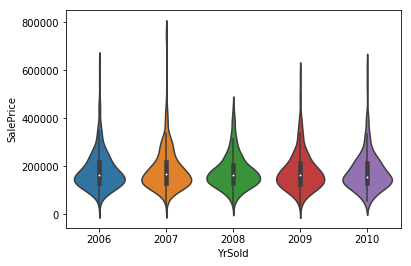

In [7]:
fig, ax = plt.subplots()
# sns.barplot(x='YrSold', y='LogPrice', data=train, ax=ax)
# sns.barplot(x='YrSold', y='SalePrice', data=train, ax=ax)
sns.violinplot(x='YrSold', y='SalePrice', data=train, ax=ax);

seems it is alright to leave the YrSold along

In [8]:
full_feature_list = cor_table[2:]
processed_train, processed_test = pd.DataFrame(), pd.DataFrame()
processed_train['LogPrice'] = train.LogPrice
o_all = [train, test]
p_all = [processed_train, processed_test]
print(full_feature_list[:6])

                 feature       cor    logcor
OverallQual  OverallQual  0.790982  0.817184
GrLivArea      GrLivArea  0.708624  0.700927
GarageCars    GarageCars  0.640409  0.680625
GarageArea    GarageArea  0.623431  0.650888
TotalBsmtSF  TotalBsmtSF  0.613581  0.612134
1stFlrSF        1stFlrSF  0.605852  0.596981


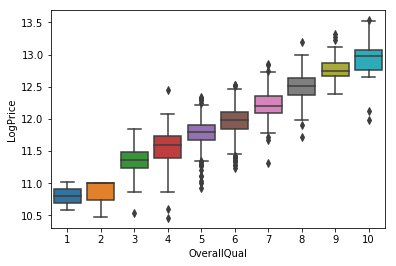

In [9]:
sns.boxplot(x='OverallQual',y='LogPrice',data=train);

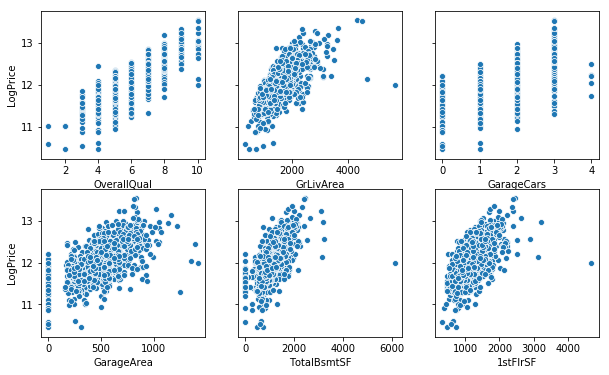

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True,figsize=(10,6))
# sns.scatterplot(x=train.OverallQual, y=train.LogPrice, ax=axs[0][0])
# sns.scatterplot(x=train.GrLivArea, y=train.LogPrice, ax=axs[0][1])
# sns.scatterplot(x=train.GarageCars, y=train.LogPrice, ax=axs[0][2])
# sns.scatterplot(x=train.GarageArea, y=train.LogPrice, ax=axs[1][0])
# sns.scatterplot(x=train.TotalBsmtSF, y=train.LogPrice, ax=axs[1][1])
# sns.scatterplot(x=train['1stFlrSF'], y=train.LogPrice, ax=axs[1][2]);

for f, n in zip(full_feature_list.index[:6],range(6)):
    sns.scatterplot(x=train[f], y=train.LogPrice, ax=axs[int(n/3)][n%3]);


keep OverallQual as is; combine GarageCars*GrarageArea; combine GrLivArea+1stFlrSF

In [11]:
rmse_log = []

In [12]:
for df1, df2 in zip(o_all, p_all):
    df2['OverallQual'] = df1['OverallQual'].astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.04995157 0.04990478 0.06078261 0.06420376 0.06419778 0.0463281
 0.04254785 0.04760145 0.05234256 0.05312555]
0.05309860039911738 0.23043133554080136 1.2591430059437345


In [13]:
for df1, df2 in zip(o_all, p_all):
    df2['Garage'] = (df1.GarageCars*df1.GarageArea).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.0449328  0.03951493 0.04759658 0.05510532 0.05479761 0.03719802
 0.0376253  0.03919376 0.0454517  0.04500206]
0.044641806291236256 0.21128607689868317 1.2352656854955035


In [14]:
for df1, df2 in zip(o_all, p_all):
    df2['LivingArea'] = (df1.GrLivArea+df1['1stFlrSF']).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.03375136 0.02787218 0.03347194 0.04777801 0.03900876 0.02610054
 0.02894597 0.02984704 0.05950825 0.0325223 ]
0.035880634671404676 0.18942184317391877 1.2085506638140853


In [15]:
for df1, df2 in zip(o_all, p_all):
    df2['TotalBsmtSF'] = df1.TotalBsmtSF.astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.03313471 0.02753398 0.03338365 0.04771194 0.03844652 0.02600408
 0.02840666 0.02933676 0.0638864  0.03236371]
0.03602084120345659 0.18979157305701586 1.208997583724466


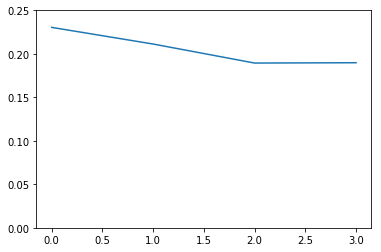

In [16]:
sns.lineplot(y=rmse_log, x=range(len(rmse_log)))
plt.ylim(0,0.25);

In [17]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler()
scaled = s.fit_transform(processed_train.drop('LogPrice', axis=1))
scaled = pd.DataFrame(scaled)
scaled['LogPrice'] = processed_train.LogPrice
feature_select_score(scaled)

[0.03313471 0.02753398 0.03338365 0.04771194 0.03844652 0.02600408
 0.02840666 0.02933676 0.0638864  0.03236371]
0.03602084120345658 0.18979157305701586 1.208997583724466


0.18979157305701586

so far the scale does not seem to affect the model

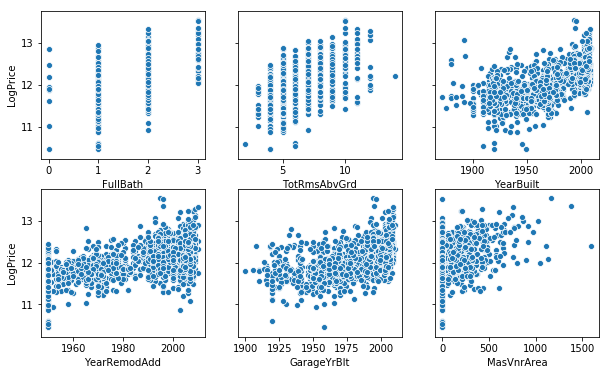

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True,figsize=(10,6))

for f, n in zip(full_feature_list.index[6:12],range(6)):
    sns.scatterplot(x=train[f], y=train.LogPrice, ax=axs[int(n/3)][n%3]);

In [19]:
for df1, df2 in zip(o_all, p_all):
    df2['FullBath'] = (df1.FullBath).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.03355787 0.02719811 0.03182993 0.04758257 0.03827264 0.02434186
 0.02829138 0.02847654 0.06163208 0.03280413]
0.03539870921029394 0.18814544695605562 1.2070090583766688


In [20]:
for df1, df2 in zip(o_all, p_all):
    df2['TotRmsAbvGrd'] = (df1.TotRmsAbvGrd).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.03400982 0.02712592 0.03172664 0.04732366 0.03849511 0.02410795
 0.02825068 0.02849334 0.06135666 0.03293347]
0.035382323806382024 0.18810189740239736 1.2069564948154832


In [21]:
for df1, df2 in zip(o_all, p_all):
    df2['YearBuilt'] = (df1.YearBuilt).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.02763458 0.02476426 0.02759778 0.04423651 0.03346187 0.02431454
 0.02577349 0.02548559 0.06150056 0.0282651 ]
0.032303428362019895 0.17973154526131438 1.1968960075840818


In [22]:
for df1, df2 in zip(o_all, p_all):
    df2['YearRemodAdd'] = (df1.YearRemodAdd).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.0260457  0.02316889 0.02695972 0.04255017 0.03053882 0.02211753
 0.02498915 0.02482175 0.06235858 0.02822649]
0.03117768046381967 0.1765720262777195 1.1931203596832256


missing 81 values in 'GarageYrBlt' for houses without garages; year range from 1900 to 2010; impute na with 1790 seems reasonable

In [23]:
for df1, df2 in zip(o_all, p_all):
    df2['GarageYrBlt'] = (df1.GarageYrBlt.fillna(1790)).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.02591659 0.02262031 0.02605367 0.04134255 0.02908775 0.0226697
 0.0252844  0.02424551 0.06275951 0.02595958]
0.03059395751009423 0.17491128468482023 1.1911405395164525


8 missing values in 'MasVnrArea' and 861 observation of '0.0'; not quite sure the reason of missing, impute with median

In [24]:
for df1, df2 in zip(o_all, p_all):
    df2['MasVnrArea'] = (df1.MasVnrArea.fillna(df1.MasVnrArea.median())).astype('float64')
rmse_log.append(feature_select_score(processed_train))

[0.02599818 0.02262124 0.02611687 0.04181168 0.02901191 0.02259557
 0.02521    0.02417161 0.06277242 0.02607138]
0.030638086571862632 0.17503738621181086 1.1912907536282613


In [25]:
s = MinMaxScaler()
scaled = s.fit_transform(processed_train.drop('LogPrice', axis=1))
scaled = pd.DataFrame(scaled)
scaled['LogPrice'] = processed_train.LogPrice
feature_select_score(scaled)

[0.02599818 0.02262124 0.02611687 0.04181168 0.02901191 0.02259557
 0.02521    0.02417161 0.06277242 0.02607138]
0.030638086571862632 0.17503738621181086 1.1912907536282613


0.17503738621181086

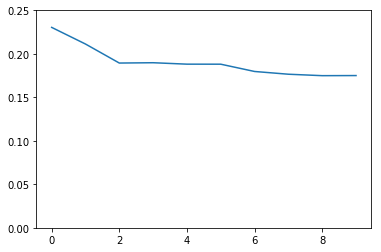

In [26]:
sns.lineplot(y=rmse_log, x=range(len(rmse_log)))
plt.ylim(0,0.25);

does not seems right; there maybe some problem with the scaling; but anyway, let's do a model for 2nd submission

In [27]:
lr = LinearRegression()
lr.fit(processed_train.drop('LogPrice', axis=1),processed_train.LogPrice)
y_pred = lr.predict(processed_test.fillna(processed_test.mean()))
output = pd.DataFrame({'Id':test.Id, 'SalePrice':np.exp(y_pred)})
output.head()

,Id,SalePrice
0,1461,115984.167953
1,1462,146535.632099
2,1463,157195.630060
3,1464,176522.996644
4,1465,207687.263182


In [28]:
output.to_csv('lr_submission02.csv', index=None)